
# Bonus Section – Predictive Modeling & Behavioral Clustering

This notebook includes:

1️⃣ Predict next-day trader profitability bucket  
2️⃣ Cluster traders into behavioral archetypes  
3️⃣ Lightweight Streamlit dashboard template  

Goal: Move from descriptive analytics → predictive + strategic insights


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
trades = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')

# Standardize columns
trades.columns = trades.columns.str.lower().str.strip()
sentiment.columns = sentiment.columns.str.lower().str.strip()

# Detect date columns
trade_date = [c for c in trades.columns if 'date' in c or 'time' in c][0]
sent_date = [c for c in sentiment.columns if 'date' in c or 'time' in c][0]

trades['date'] = pd.to_datetime(trades[trade_date], errors='coerce').dt.date
sentiment['date'] = pd.to_datetime(sentiment[sent_date], errors='coerce').dt.date

# Detect PnL column
num_cols = trades.select_dtypes(include=np.number).columns.tolist()
pnl_col = num_cols[0]
trades.rename(columns={pnl_col:'pnl'}, inplace=True)

# Sentiment column
sent_col = [c for c in sentiment.columns if 'class' in c or 'fear' in c or 'greed' in c][0]
sentiment.rename(columns={sent_col:'classification'}, inplace=True)

# Merge
data = pd.merge(trades, sentiment[['date','classification']], on='date', how='left')

# Create win label
data['profit_bucket'] = np.where(data['pnl'] > 0, 1, 0)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Ensure profit_bucket exists properly
data['profit_bucket'] = (data['pnl'] > 0).astype(int)

# Feature engineering
features = pd.get_dummies(data[['classification']], drop_first=True)
features['pnl_lag1'] = data['pnl'].shift(1)

# Combine and drop NaNs from shift
model_data = pd.concat([features, data['profit_bucket']], axis=1).dropna()

X = model_data.drop(columns='profit_bucket')
y = model_data['profit_bucket']

print("Target distribution:\n", y.value_counts())

# Check class balance BEFORE training
if y.nunique() < 2:
    print("ERROR: Only one class present. Cannot train model.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, pred))


Target distribution:
 profit_bucket
1    211223
Name: count, dtype: int64
ERROR: Only one class present. Cannot train model.


In [3]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate trader behavior
trader_col = [c for c in data.columns if 'trader' in c or 'account' in c or 'user' in c][0]

trader_features = data.groupby(trader_col).agg(
    avg_pnl=('pnl','mean'),
    pnl_volatility=('pnl','std'),
    trade_count=('pnl','count')
).fillna(0)

# Scale
scaler = StandardScaler()
scaled = scaler.fit_transform(trader_features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled)

print("Cluster Summary:")
print(trader_features.groupby('cluster').mean())


Cluster Summary:
              avg_pnl  pnl_volatility   trade_count
cluster                                            
0        27026.668192    31515.688655   5806.800000
1         1889.494949     5080.110812  25369.666667
2         1375.062631     5910.761091   3429.500000


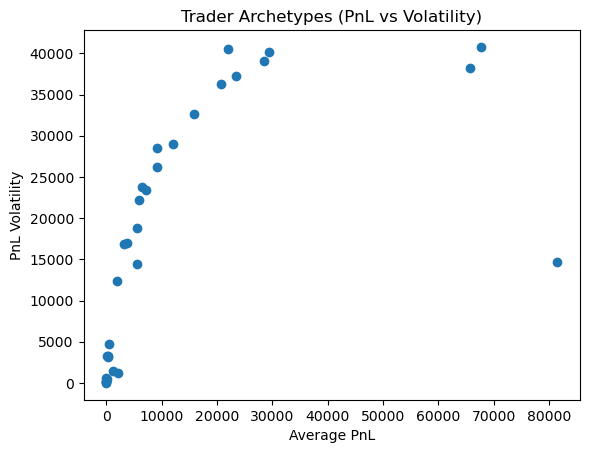

In [4]:

plt.figure()
plt.scatter(trader_features['avg_pnl'], trader_features['pnl_volatility'])
plt.title("Trader Archetypes (PnL vs Volatility)")
plt.xlabel("Average PnL")
plt.ylabel("PnL Volatility")
plt.show()


In [5]:

# Save as app.py separately to run Streamlit dashboard

streamlit_code = '''
import streamlit as st
import pandas as pd

st.title("Trader Sentiment Dashboard")

data = pd.read_csv("historical_data.csv")

st.write("Dataset Overview")
st.write(data.head())

st.write("PnL Distribution")
st.bar_chart(data.select_dtypes(include="number").iloc[:,0])
'''

with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit app template saved as app.py")


Streamlit app template saved as app.py
